In [ ]:
# 3L_SDVRP 

In [2]:
from container_packing.shortcuts import pack_products_into_restrictions

help(pack_products_into_restrictions)
boxes = [{
  'x': 12,
  'y': 13,
  'z': 30,
  'quantity': 2
}, {
  'x': 12,
  'y': 23,
  'z': 40,
  'quantity': 4
}]

conataner_max_sizes = (60, 60, 90)

container_x, container_y, container_z = pack_products_into_restrictions(
    boxes,
    conataner_max_sizes
)


Help on function pack_products_into_restrictions in module container_packing.shortcuts:

pack_products_into_restrictions(products: List[Union[tuple, dict]], restrictions: tuple) -> Union[tuple, NoneType]
    Pack product into container with given restrictions.
    
    :param products: list with tuples of width, depth and height of product
         or with dicts with with (key x), depth (y), height (z) and quantity,
    :param restrictions: tuple with width, depth and height of container,
    :return: tuple with minimal width, depth and height of container
        that can hold all products or None if there is no container with
        given restrictions.



In [16]:
"""Vehicles Routing Problem (VRP)."""

from __future__ import print_function
from ortools.constraint_solver import routing_enums_pb2
from ortools.constraint_solver import pywrapcp


def create_data_model():
    """Stores the data for the problem."""
    data = {}
    data['distance_matrix'] = [
        [
            0, 548, 776, 696, 582, 274, 502, 194, 308, 194, 536, 502, 388, 354,
            468, 776, 662
        ],
        [
            548, 0, 684, 308, 194, 502, 730, 354, 696, 742, 1084, 594, 480, 674,
            1016, 868, 1210
        ],
        [
            776, 684, 0, 992, 878, 502, 274, 810, 468, 742, 400, 1278, 1164,
            1130, 788, 1552, 754
        ],
        [
            696, 308, 992, 0, 114, 650, 878, 502, 844, 890, 1232, 514, 628, 822,
            1164, 560, 1358
        ],
        [
            582, 194, 878, 114, 0, 536, 764, 388, 730, 776, 1118, 400, 514, 708,
            1050, 674, 1244
        ],
        [
            274, 502, 502, 650, 536, 0, 228, 308, 194, 240, 582, 776, 662, 628,
            514, 1050, 708
        ],
        [
            502, 730, 274, 878, 764, 228, 0, 536, 194, 468, 354, 1004, 890, 856,
            514, 1278, 480
        ],
        [
            194, 354, 810, 502, 388, 308, 536, 0, 342, 388, 730, 468, 354, 320,
            662, 742, 856
        ],
        [
            308, 696, 468, 844, 730, 194, 194, 342, 0, 274, 388, 810, 696, 662,
            320, 1084, 514
        ],
        [
            194, 742, 742, 890, 776, 240, 468, 388, 274, 0, 342, 536, 422, 388,
            274, 810, 468
        ],
        [
            536, 1084, 400, 1232, 1118, 582, 354, 730, 388, 342, 0, 878, 764,
            730, 388, 1152, 354
        ],
        [
            502, 594, 1278, 514, 400, 776, 1004, 468, 810, 536, 878, 0, 114,
            308, 650, 274, 844
        ],
        [
            388, 480, 1164, 628, 514, 662, 890, 354, 696, 422, 764, 114, 0, 194,
            536, 388, 730
        ],
        [
            354, 674, 1130, 822, 708, 628, 856, 320, 662, 388, 730, 308, 194, 0,
            342, 422, 536
        ],
        [
            468, 1016, 788, 1164, 1050, 514, 514, 662, 320, 274, 388, 650, 536,
            342, 0, 764, 194
        ],
        [
            776, 868, 1552, 560, 674, 1050, 1278, 742, 1084, 810, 1152, 274,
            388, 422, 764, 0, 798
        ],
        [
            662, 1210, 754, 1358, 1244, 708, 480, 856, 514, 468, 354, 844, 730,
            536, 194, 798, 0
        ],
    ]
    data['num_vehicles'] = 1
    data['depot'] = 0
    return data
def print_solution(data, manager, routing, solution):
    """Prints solution on console."""
    max_route_distance = 0
    for vehicle_id in range(data['num_vehicles']):
        index = routing.Start(vehicle_id)
        plan_output = 'Route for vehicle {}:\n'.format(vehicle_id)
        route_distance = 0
        while not routing.IsEnd(index):
            plan_output += ' {} -> '.format(manager.IndexToNode(index))
            previous_index = index
            index = solution.Value(routing.NextVar(index))
            route_distance += routing.GetArcCostForVehicle(
                previous_index, index, vehicle_id)
        plan_output += '{}\n'.format(manager.IndexToNode(index))
        plan_output += 'Distance of the route: {}m\n'.format(route_distance)
        print(plan_output)
        max_route_distance = max(route_distance, max_route_distance)
    print('Maximum of the route distances: {}m'.format(max_route_distance))
def main():
    """Solve the CVRP problem."""
    # Instantiate the data problem.
    data = create_data_model()

    # Create the routing index manager.
    manager = pywrapcp.RoutingIndexManager(len(data['distance_matrix']),
                                           data['num_vehicles'], data['depot'])

    # Create Routing Model.
    routing = pywrapcp.RoutingModel(manager)


    # Create and register a transit callback.
    def distance_callback(from_index, to_index):
        """Returns the distance between the two nodes."""
        # Convert from routing variable Index to distance matrix NodeIndex.
        from_node = manager.IndexToNode(from_index)
        to_node = manager.IndexToNode(to_index)
        return data['distance_matrix'][from_node][to_node]

    transit_callback_index = routing.RegisterTransitCallback(distance_callback)

    # Define cost of each arc.
    routing.SetArcCostEvaluatorOfAllVehicles(transit_callback_index)

    # Add Distance constraint.
    dimension_name = 'Distance'
    routing.AddDimension(
        transit_callback_index,
        0,  # no slack
        3000,  # vehicle maximum travel distance
        True,  # start cumul to zero
        dimension_name)
    distance_dimension = routing.GetDimensionOrDie(dimension_name)
    distance_dimension.SetGlobalSpanCostCoefficient(100)

    # Setting first solution heuristic.
    search_parameters = pywrapcp.DefaultRoutingSearchParameters()
    search_parameters.first_solution_strategy = (
        routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC)

    # Solve the problem.
    solution = routing.SolveWithParameters(search_parameters)

    # Print solution on console.
    if solution:
        print_solution(data, manager, routing, solution)


if __name__ == '__main__':
    main()


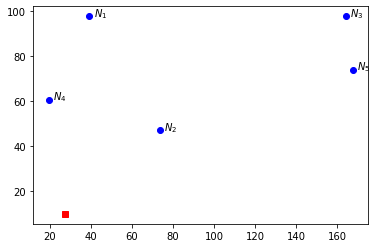

In [142]:
import numpy as np
import matplotlib.pyplot as plt

# "rnd" is an object that generate random numbers.
rnd = np.random
#"seed(0)" is a method that reset (every time), the same random set of numbers.
rnd.seed(0)
# Number of customers.
n_customer = 5
# Maximum Volum that container can carry
Q = 100
# Maximum Weight that container can carry
S = 100
#The set of nodes without the depot.
N = [i for i in range(1,n_customer+1)]
# The set of nodes + the depot.
V = [0]+ N
# Generating each collection point cargoes
IT = [((rnd.randint(1, 10), rnd.randint(1, 10), rnd.randint(1, 10)), (rnd.randint(1, 10), rnd.randint(1, 10), rnd.randint(1, 10)), (rnd.randint(1, 10), rnd.randint(1, 10), rnd.randint(1, 10)), (rnd.randint(1, 10), rnd.randint(1, 10), rnd.randint(1, 10)), (rnd.randint(1, 10), rnd.randint(1, 10), rnd.randint(1, 10))) for i in N ]# A collection that contains the demand of each node.
q = {i: rnd.randint(1, 10) for i in N}
# Generating random numbers between (0 and 15) * 200.
xc = rnd.rand(n_customer+1)*200
# Generating random numbers between (0 and 15) * 100.
yc = rnd.rand(n_customer+1)*100
# Define number of Routing plans
RP = 100
#Plotting the n nodes without the node 0 (depot) and chose the color blue for each node.
plt.scatter(xc[1:],yc[1:],c='b')
# Associating and plotting each demand in the right of each blue node (customer).
for i in N:
    plt.annotate('$N_%d$'%(i),(xc[i]+2,yc[i]))
#Ploting the node 0, chosing the red like its color and the square form like a marker.
plt.plot(xc[0],yc[0],c='r' ,marker='s')
#Showing the Initial plot.
plt.show()
#Intializing the set of arcs A.
A = [(i,j) for i in V for j in V if i!=j]
#Calculating the distance between each node.
dist= {(i, j): np.hypot(xc[i]-xc[j], yc[i]-yc[j]) for i, j in A}


In [143]:
##################################################
# matrix of transition probabilities sampled from a Dirichlet
##################################################
from scipy.stats import multinomial
from scipy.stats import dirichlet
import numpy as np

historical_routes = [rnd.randint(1, 100) for i in range(0, len(A))]
alpha = np.array(historical_routes)  # specify concentration parameters
drichlet_mean = dirichlet.mean(alpha)
multinomial_ed = multinomial.rvs( n_customer, drichlet_mean, size=RP)

multinomial_ed

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0],
       ...,
       [0, 0, 1, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [144]:
# Finding Edges

semi_final_path = []

for routplansiterator in range(0, len(multinomial_ed)):
    sorted_edges=[]
    for maxifinder in range(max(multinomial_ed[routplansiterator]), -1, -1):
        finded = np.where(multinomial_ed[routplansiterator] == maxifinder)
        sorted_edges.append(finded[0])
    first_path = []
    for hh in sorted_edges:
        for ff in hh:
            first_path.append(A[ff])
        
    semi_final_path.append(first_path[0:n_customer])

semi_final_path[0:10]


[[(2, 0), (1, 0), (3, 1), (5, 0), (0, 1)],
 [(4, 1), (0, 4), (4, 5), (5, 0), (0, 1)],
 [(0, 5), (0, 3), (2, 0), (3, 5), (0, 1)],
 [(2, 3), (5, 3), (3, 5), (0, 1), (0, 2)],
 [(1, 3), (2, 3), (3, 0), (3, 1), (5, 0)],
 [(0, 4), (1, 0), (1, 4), (4, 0), (4, 5)],
 [(1, 3), (1, 5), (2, 4), (4, 0), (5, 0)],
 [(0, 3), (0, 5), (1, 0), (2, 0), (3, 0)],
 [(1, 0), (2, 0), (2, 1), (2, 3), (5, 4)],
 [(0, 3), (2, 0), (3, 0), (5, 3), (5, 4)]]

In [145]:
# removing invalid routes

numfailed = []
for rpiterator in range(0,len(semi_final_path)):
    starting_point=0
    for jkl in semi_final_path[rpiterator]:
        starting_point=starting_point+1
        for lkj in semi_final_path[rpiterator][starting_point:]:
            if (jkl[1] == lkj[0] and jkl[0] == lkj[1]):
                numfailed.append(rpiterator)
final_path = [i for n, i in enumerate(semi_final_path) if n not in numfailed]
final_path[0:10]

[[(4, 1), (0, 4), (4, 5), (5, 0), (0, 1)],
 [(0, 5), (0, 3), (2, 0), (3, 5), (0, 1)],
 [(1, 3), (1, 5), (2, 4), (4, 0), (5, 0)],
 [(1, 0), (2, 0), (2, 1), (2, 3), (5, 4)],
 [(0, 5), (2, 0), (2, 5), (3, 1), (4, 5)],
 [(1, 3), (2, 0), (2, 3), (3, 0), (0, 1)],
 [(1, 3), (1, 5), (3, 0), (3, 2), (5, 4)],
 [(0, 4), (0, 5), (1, 3), (2, 0), (0, 1)],
 [(2, 0), (1, 5), (4, 5), (5, 3), (0, 1)],
 [(2, 1), (2, 3), (4, 0), (5, 0), (5, 4)]]

In [146]:
##################################################
# Splitting pland
##################################################

# cluster cargoes

